## Main code to download images

In [8]:
#Import requirements
from bs4 import BeautifulSoup
import urllib
import wget
import re
from robobrowser import RoboBrowser
import pandas as pd


## 1. Read tables from CRTS of all the objects

In [2]:
df_light_curves.head() #muestra la tabla
ra_col = df_light_curves['ra']
dec_col = df_light_curves['dec']
for index, row in df_light_curves.iterrows():
    #x = np.array([row['ra'], row['dec']])
    ra_coord = row['ra']
    dec_coord = row['dec']
    str_query = str(ra_coord) + ' ' + str(dec_coord) #input para buscar


NameError: name 'df_light_curves' is not defined

## 2. Query search on Data Release 3

In [10]:
CRTS_DR3_beta_url = 'http://crts.iucaa.in/crts/'
DR3 = urllib.request.urlopen(CRTS_DR3_beta_url).read()
soup_DR3 = BeautifulSoup(DR3)#, "lxml")
print(type(soup_DR3))

<class 'bs4.BeautifulSoup'>


/Users/j1k1000o/anaconda/envs/python3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/j1k1000o/anaconda/envs/python3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html.parser")

  markup_type=markup_type))


In [36]:
#Define subsample of objects for each class
list_of_classes = []
list_of_crds = []
#### CSS telescope ####
#SN: 
str_of_crds = '142.63453' + ' ' + '20.60814'
list_of_crds.append(str_of_crds)
object_class = 'SN'
list_of_classes.append(object_class)
#CV:
str_of_crds = '157.35429' + ' ' + '61.47645'
list_of_crds.append(str_of_crds)
object_class = 'CV'
list_of_classes.append(object_class)
#BZ:
str_of_crds = '342.49855' + ' ' + '-12.85467'
list_of_crds.append(str_of_crds)
object_class = 'BZ'
list_of_classes.append(object_class)
#AGN:
str_of_crds = '24.14416' + ' ' + '19.57569'
list_of_crds.append(str_of_crds)
object_class = 'AGN'
list_of_classes.append(object_class)
#FLARES:
str_of_crds = '352.68174' + ' ' + '14.08518'
list_of_crds.append(str_of_crds)
object_class = 'FLARES'
list_of_classes.append(object_class)
#OTHER: 
str_of_crds = '80.22595' + ' ' + '21.99364'
list_of_crds.append(str_of_crds)
object_class = 'OTHER'
list_of_classes.append(object_class)
print(list_of_classes, list_of_crds)

['SN', 'CV', 'BZ', 'AGN', 'FLARES', 'OTHER'] ['142.63453 20.60814', '157.35429 61.47645', '342.49855 -12.85467', '24.14416 19.57569', '352.68174 14.08518', '80.22595 21.99364']


In [41]:
#do this for each TO
browser = RoboBrowser()
browser.open(CRTS_DR3_beta_url)
form = browser.get_form(action='/crts/imaging')
# print(form)
def download_images_per_object (list_of_crds, obj_class):
    form['imaging-search-query'].value = '332.64277 -22.66323' #'X' + ' ' + 'Y'
    form['imaging-search-radius'].value = '0.1'
    browser.submit_form(form) 
    #search: se actualiza la variable de browser 
    #duda: hay una forma de pedir la nueva url de esa pagina?

    #Find all the "values" or images for that object
    num = browser.find("div", {"class" : "Found"})
    complete_string = num.getText()
    total = [int(s) for s in complete_string.split() if s.isdigit()] #extraer el numero que corresponde a las ims
    list_of_numbers = list(range(0, int(total[0])-1))
    str_list_values = []
    for i in range(int(total[0])):
        a = i
        str_list_values.append(str(a))
    
    #extract information from the table
    #browser_html_code = browser.parsed() #type: <class 'bs4.element.ResultSet'>
    #first_element = browser_html_code[0] #type: <class 'bs4.element.Tag'>
    #text = first_element.getText()

    #x = browser.find("div", {"id" : "outTable"})
    #select only the table 
    read_table = browser.find("table", {"class" : "sortable"})  #type: <class 'bs4.element.Tag'>
    string_all_rows_table = read_table.getText()
    #print('what I found:', string_all_rows_table)
    list_all_rows_table = string_all_rows_table.strip().split()
    data_information = list_all_rows_table[4:]
    #extract info from each column
    center_ra_list = data_information[::4]
    center_dec_list = data_information[1::4] 
    obs_date_list = data_information[2::4]
    file_name_list = data_information[3::4]
    #create dataframe
    data = {list_all_rows_table[0] : center_ra_list, list_all_rows_table[1] : center_dec_list, 
        list_all_rows_table[2] : obs_date_list, list_all_rows_table[3] : file_name_list}
    df_per_object = pd.DataFrame(data)
    df_per_object.head()
    #print('html code:', browser.parsed()) #lo que está viendo de html

    #Proceed to download all the images of the object 
    print('*************')
    new_form = browser.get_form(action='/crts/download')
    print(new_form)
    # image = browser.get_form(class_='imaging-search-query')
    #print(image)
    # extraer todos los values con browser.find

    #new_form['downloadSelector'] = ['49','2'] #chulear el que tenga ese value
    new_form['downloadSelector'] = str_list_values
    browser.submit_form(new_form) #queda con un click here to download/se actualiza la pagina

    #se abre otra pagina
    link =browser.find("a", { "class" : "downloadLink" })
    download_zip = link.get('href')
    base_url = 'http://crts.iucaa.in'
    download_zip = base_url + download_zip
    #out_dir = '/home/oem/Documentos/Astronomy/CRTS/Data/'
    out_dir = '/Users/j1k1000o/Documents/Cata/Data/'
    object_class = obj_class
    complete_path = out_dir + object_class + '/' 
    file_name = 'first_object.zip'
    print(complete_path + file_name)
    wget.download(download_zip, complete_path + file_name)
    #print(download_zip)
    #save DF file with metadata
    #df_per_object.to_pickle(complete_path + file_name[0:-4] + '/' + file_name[0:-4] + '.pkl')
    df_per_object.to_pickle(complete_path + file_name[0:-4] + '.pkl')

 

/Users/j1k1000o/anaconda/envs/python3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/j1k1000o/anaconda/envs/python3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html.parser")

  markup_type=markup_type))


In [42]:
cont = 0
print(list_of_classes)
for object_class in list_of_classes:
    print(object_class)
    download_images_per_object(list_of_crds[cont], object_class)
    cont = cont + 1

['SN', 'CV', 'BZ', 'AGN', 'FLARES', 'OTHER']
SN


/Users/j1k1000o/anaconda/envs/python3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/j1k1000o/anaconda/envs/python3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html.parser")

  markup_type=markup_type))


*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_224825990165.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
/Users/j1k1000o/Documents/Cata/Data/SN/first_object.zip
CV
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_224845138847.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
/Users/j1k1000o/Documents/Cata/Data/CV/first_object.zip
BZ
*************
<RoboForm resultsTable=/opt/www/crtsDR3/crtsDR3/staging/im332p64277_-22p66323_0p1_224901028021.dat, ra=332.64277, dec=-22.66323, radius=0.1, imageType=CutOuts, downloadSelector=[]>
/Users/j1k1000o/Documents/Cata/Data/BZ/first_object.zip


FileNotFoundError: [Errno 2] No such file or directory: '/Users/j1k1000o/Documents/Cata/Data/BZ/first_object.zipdknwfo4s.tmp'

## 3. Read fits images

In [45]:
from astropy.io import fits
from astropy import wcs
import sys
import os
import glob
import gzip
import numpy as np
import pandas as pd
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings("ignore")

Pixel coordinates: [[ 59.98307669  60.00845027]]
Date of observation: 01_03NOV2


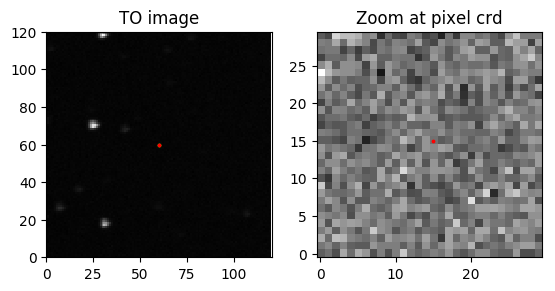

Pixel coordinates: [[ 60.02156108  70.00635594]]
Date of observation: 01_03NOV2


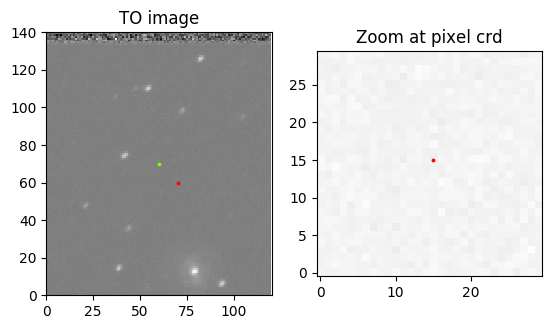

Pixel coordinates: [[ 60.02156052  70.00635959]]
Date of observation: 01_03NOV2


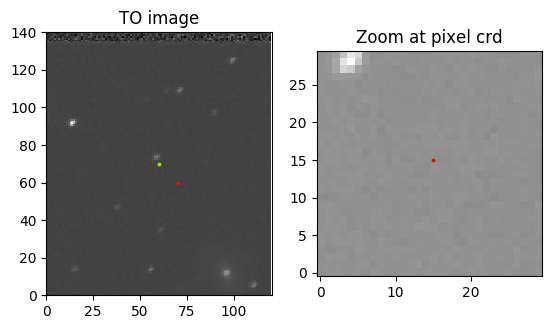

Pixel coordinates: [[ 60.02156075  70.00636252]]
Date of observation: 01_03NOV2


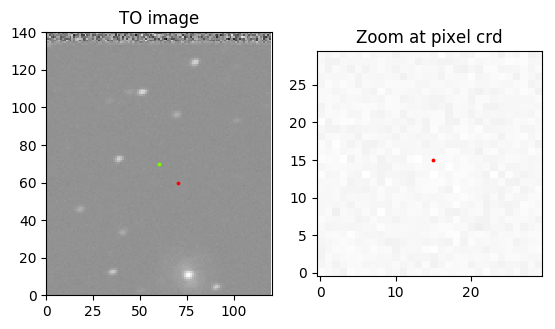

Pixel coordinates: [[ 60.0183369   60.00704053]]
Date of observation: 01_03NOV2


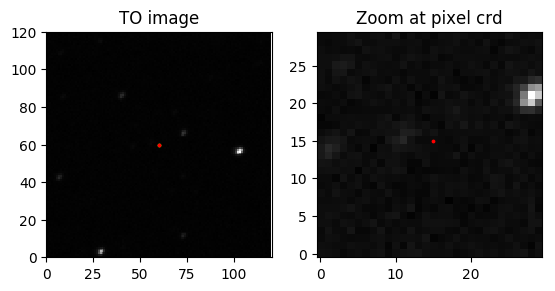

Pixel coordinates: [[ 60.02155867  70.00636627]]
Date of observation: 01_03NOV2


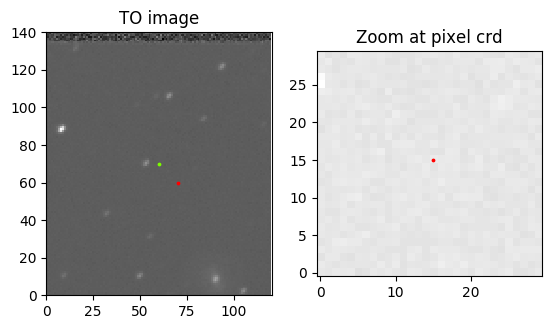

Pixel coordinates: [[ 60.01831403  60.00690441]]
Date of observation: 01_05NOV1


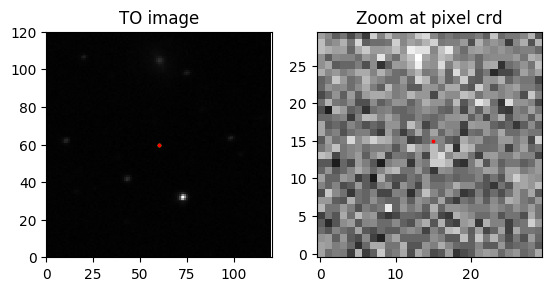

Pixel coordinates: [[ 60.02093936  68.00632995]]
Date of observation: 01_05OCT1


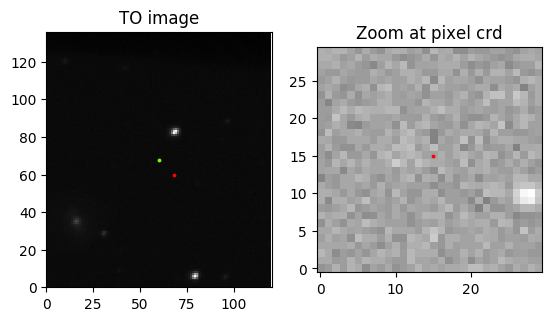

Pixel coordinates: [[ 60.02092376  68.00632741]]
Date of observation: 01_05OCT1


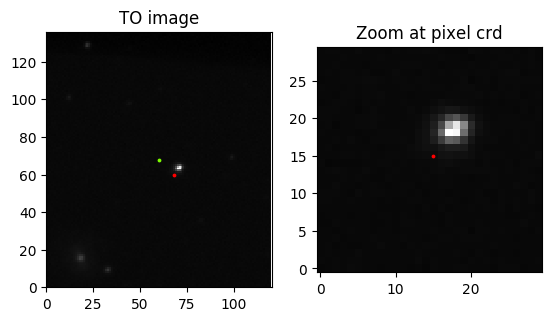

Pixel coordinates: [[ 60.02094194  68.0063371 ]]
Date of observation: 01_05OCT1


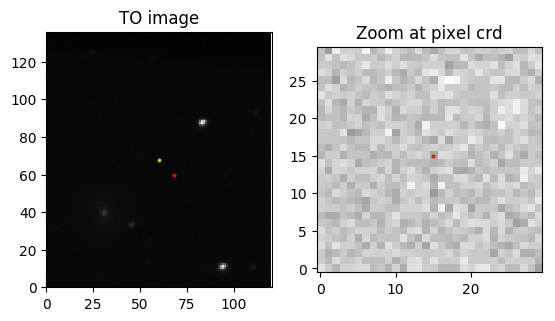

Pixel coordinates: [[ 60.02093779  68.00634001]]
Date of observation: 01_05OCT1


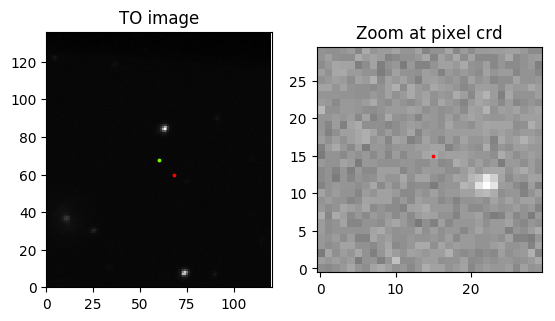

Pixel coordinates: [[ 59.97892207  68.00627301]]
Date of observation: 01_05SEP2


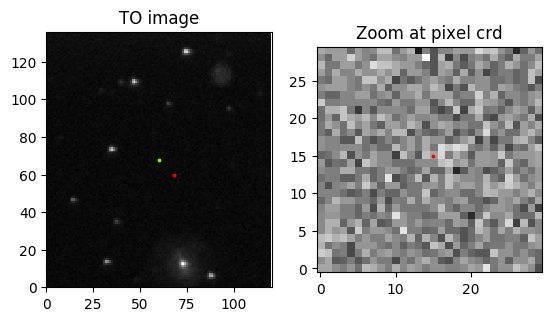

Pixel coordinates: [[ 59.98147802  60.00693049]]
Date of observation: 01_05SEP2


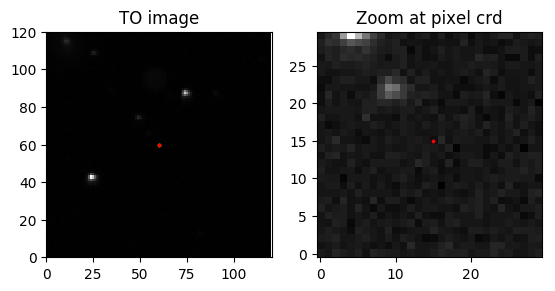

Pixel coordinates: [[ 59.97885565  68.00636796]]
Date of observation: 01_05SEP2


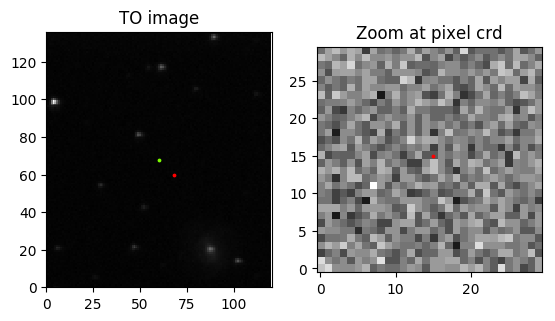

Pixel coordinates: [[ 59.97879839  68.00646318]]
Date of observation: 01_05SEP2


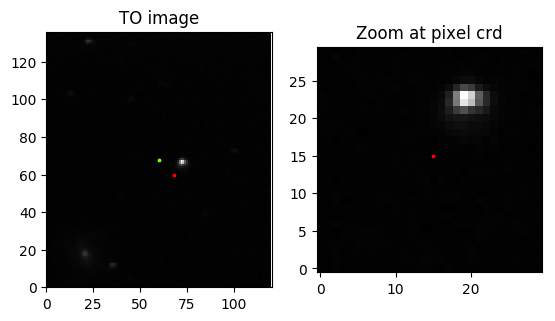

Pixel coordinates: [[ 60.01829648  60.00688918]]
Date of observation: 01_06NOV1


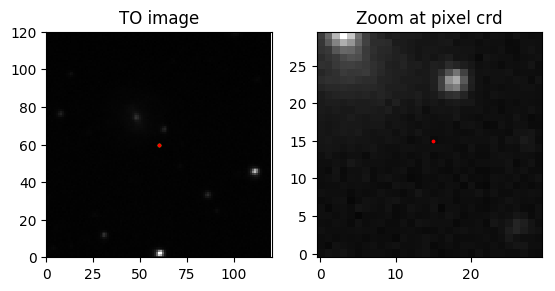

Pixel coordinates: [[ 60.01831142  60.00689943]]
Date of observation: 01_06NOV1


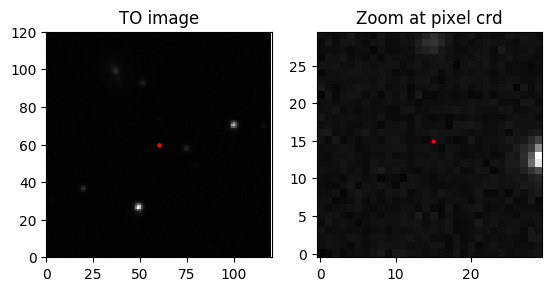

Pixel coordinates: [[ 60.01830886  60.00690127]]
Date of observation: 01_06NOV1


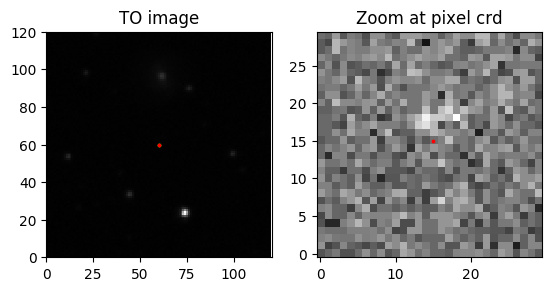

Pixel coordinates: [[ 60.02109307  68.00617333]]
Date of observation: 01_07OCT1


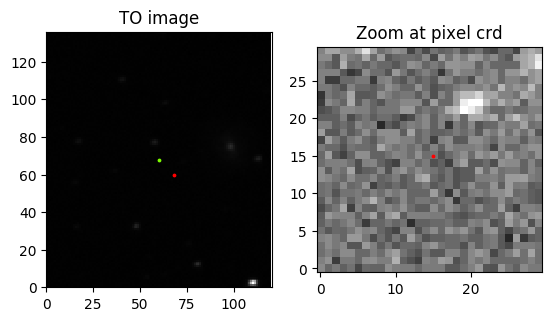

Pixel coordinates: [[ 60.02108038  68.00616883]]
Date of observation: 01_07OCT1


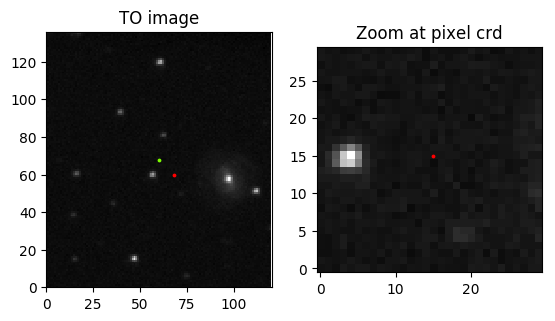

Pixel coordinates: [[ 60.02109775  68.00617688]]
Date of observation: 01_07OCT1


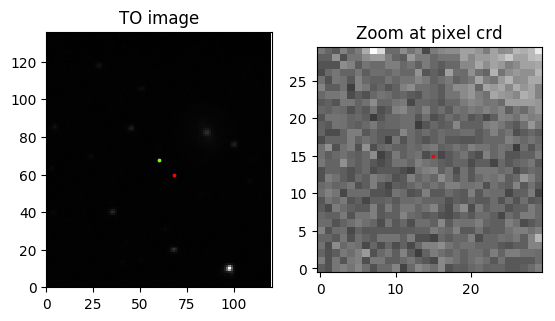

Pixel coordinates: [[ 60.02109734  68.00617732]]
Date of observation: 01_07OCT1


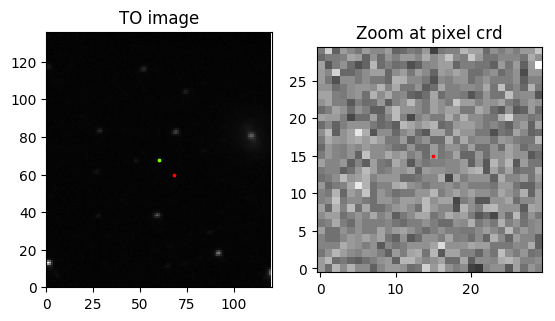

Pixel coordinates: [[ 60.0184098   60.00675704]]
Date of observation: 01_07SEP1


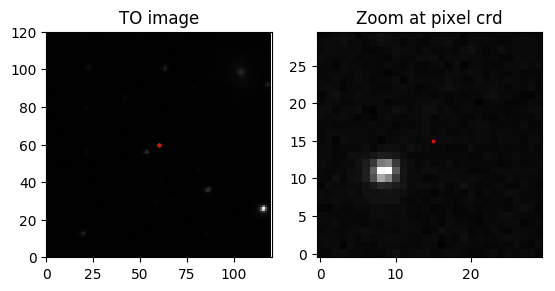

Pixel coordinates: [[ 60.01839787  60.00675314]]
Date of observation: 01_07SEP1


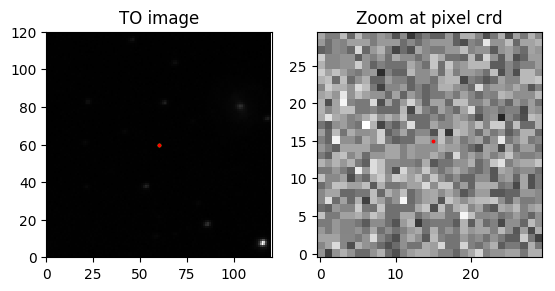

Pixel coordinates: [[ 60.01841437  60.00676251]]
Date of observation: 01_07SEP1


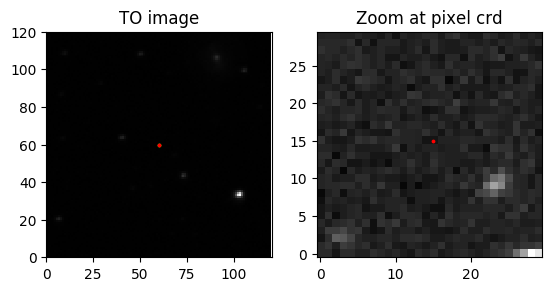

Pixel coordinates: [[ 60.01841242  60.00676328]]
Date of observation: 01_07SEP1


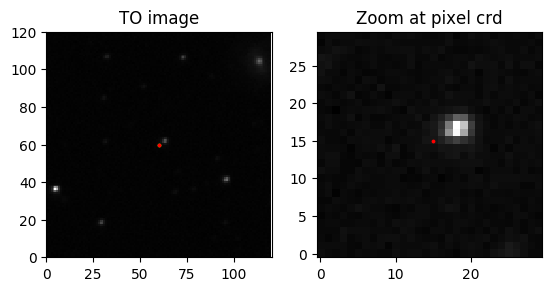

Pixel coordinates: [[ 60.01839665  60.00691495]]
Date of observation: 01_08NOV0


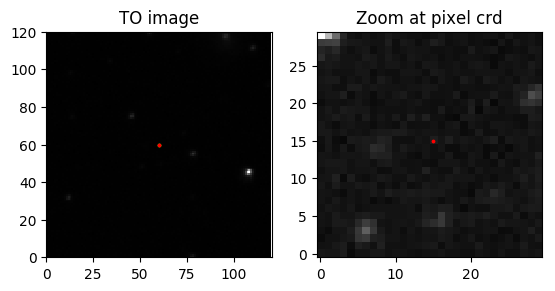

Pixel coordinates: [[ 60.02100634  68.00635653]]
Date of observation: 01_08NOV0


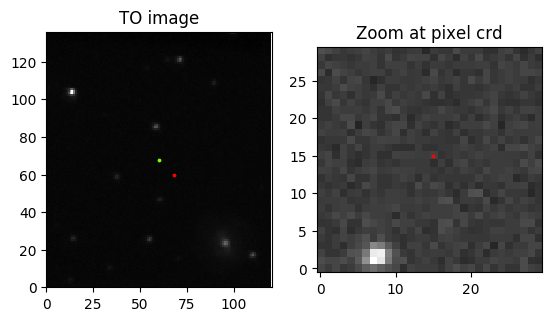

Pixel coordinates: [[ 60.02102239  68.0063656 ]]
Date of observation: 01_08NOV0


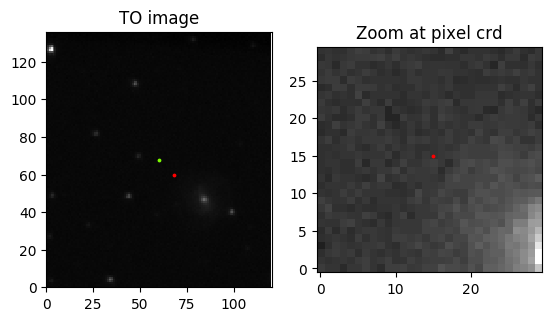

Pixel coordinates: [[ 60.02101807  68.0063673 ]]
Date of observation: 01_08NOV0


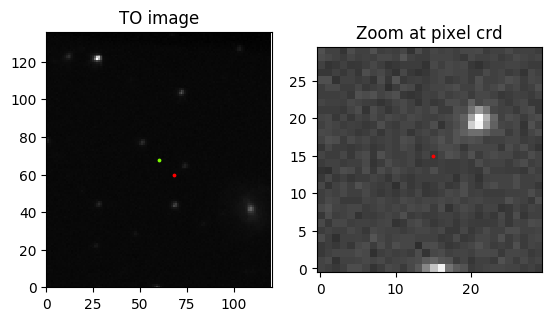

Pixel coordinates: [[ 60.01838844  60.00688844]]
Date of observation: 01_09AUG1


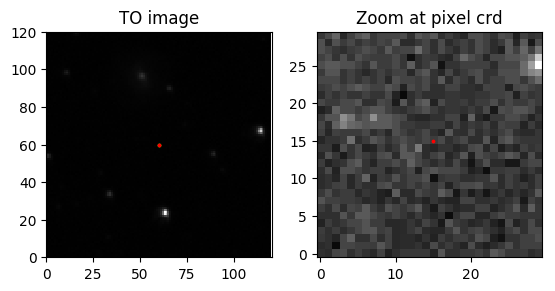

Pixel coordinates: [[ 60.01840396  60.00689849]]
Date of observation: 01_09AUG1


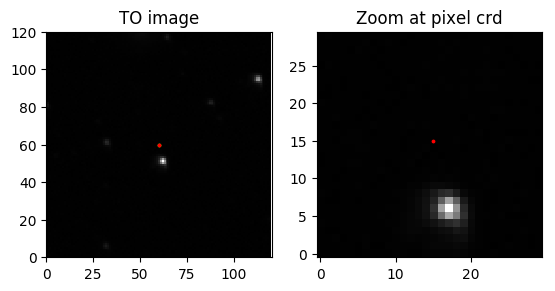

Pixel coordinates: [[ 60.02100441  68.00633288]]
Date of observation: 01_09AUG1


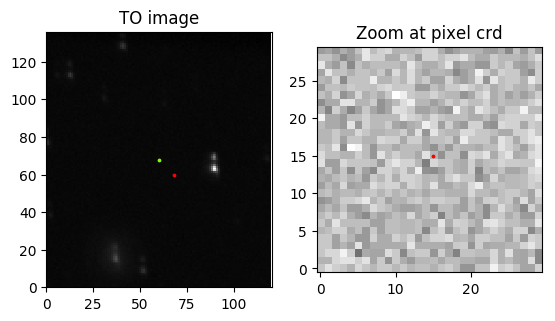

Pixel coordinates: [[ 60.02101139  68.00633684]]
Date of observation: 01_09AUG1


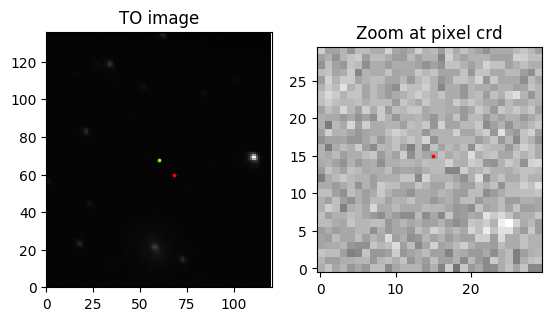

Pixel coordinates: [[ 60.01836364  60.00688885]]
Date of observation: 01_09AUG2


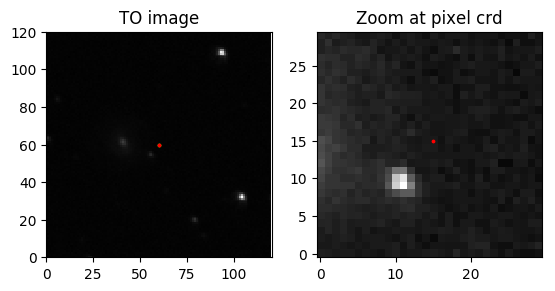

Pixel coordinates: [[ 60.01834997  60.0068851 ]]
Date of observation: 01_09AUG2


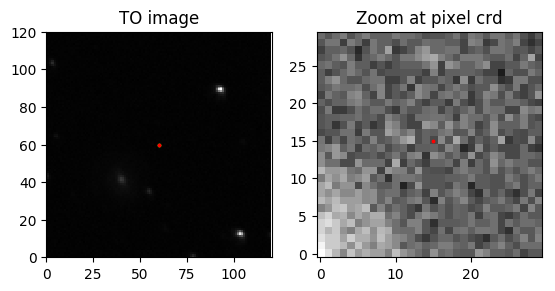

Pixel coordinates: [[ 60.0183642   60.00689387]]
Date of observation: 01_09AUG2


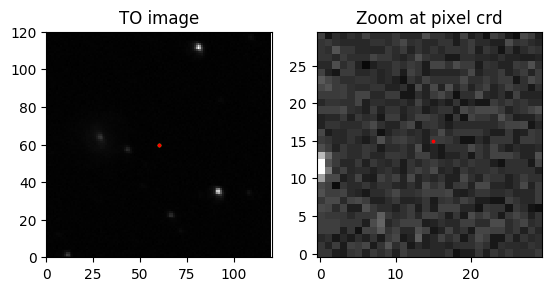

Pixel coordinates: [[ 60.01836129  60.00689529]]
Date of observation: 01_09AUG2


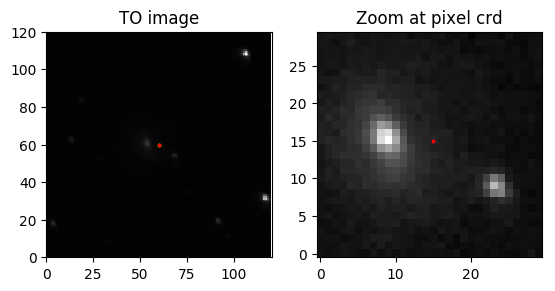

Pixel coordinates: [[ 60.01838522  60.0069049 ]]
Date of observation: 01_09SEP1


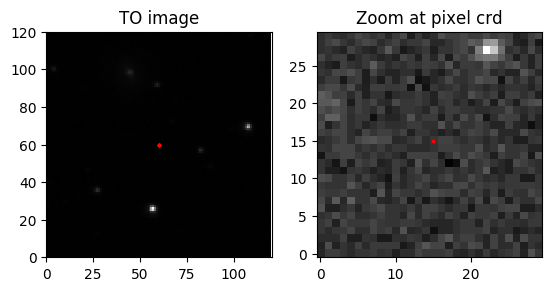

Pixel coordinates: [[ 60.018374    60.00690115]]
Date of observation: 01_09SEP1


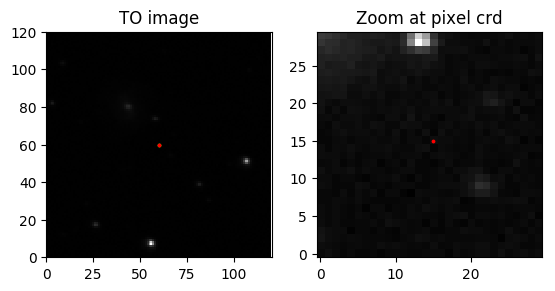

Pixel coordinates: [[ 60.01838874  60.00690981]]
Date of observation: 01_09SEP1


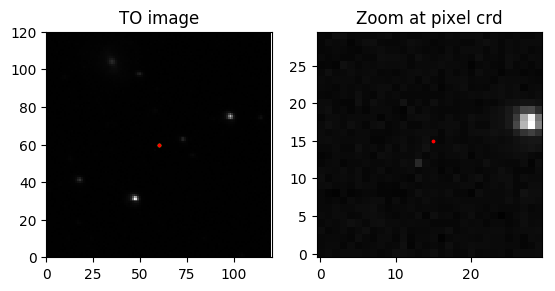

Pixel coordinates: [[ 60.0183863   60.00691113]]
Date of observation: 01_09SEP1


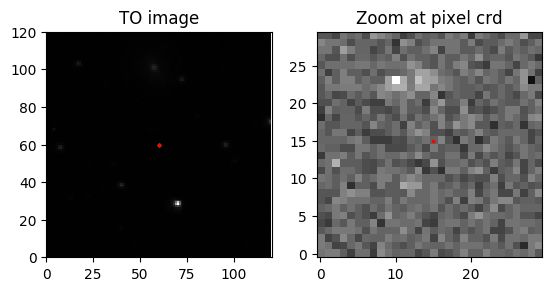

Pixel coordinates: [[ 59.98348292  60.00922927]]
Date of observation: 01_09SEP1


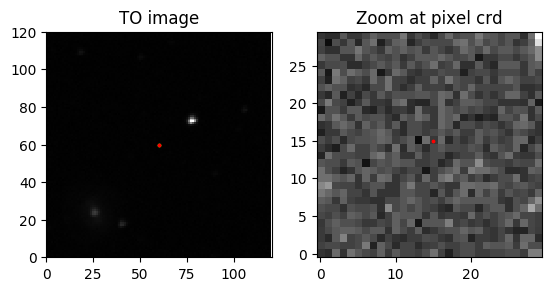

Pixel coordinates: [[ 59.9834826   60.00922134]]
Date of observation: 01_09SEP1


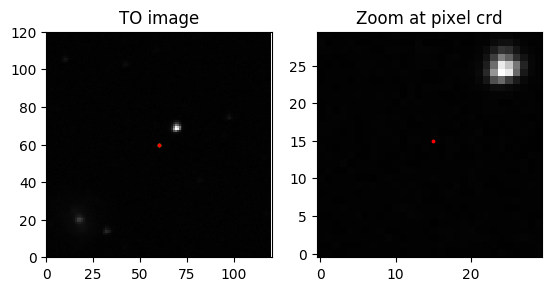

Pixel coordinates: [[ 59.98348663  60.00921461]]
Date of observation: 01_09SEP1


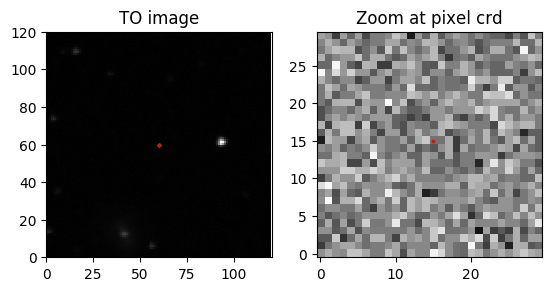

Pixel coordinates: [[ 60.02105739  68.00634578]]
Date of observation: 01_09SEP2


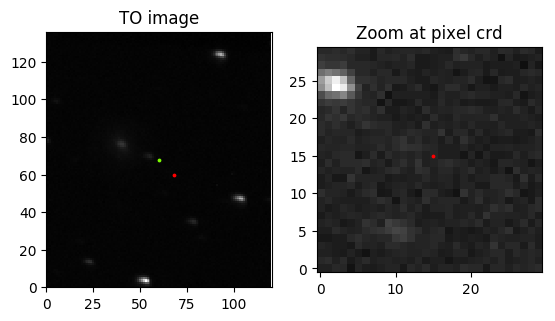

Pixel coordinates: [[ 60.02101788  68.00635547]]
Date of observation: 01_10NOV0


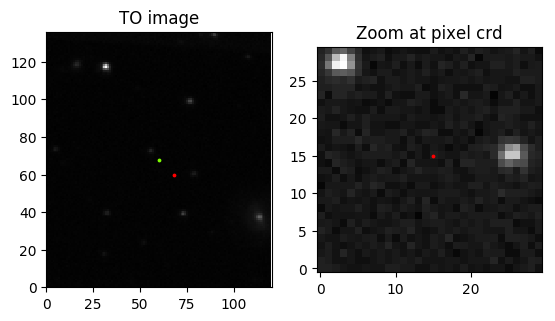

Pixel coordinates: [[ 60.01840042  60.00691787]]
Date of observation: 01_10NOV0


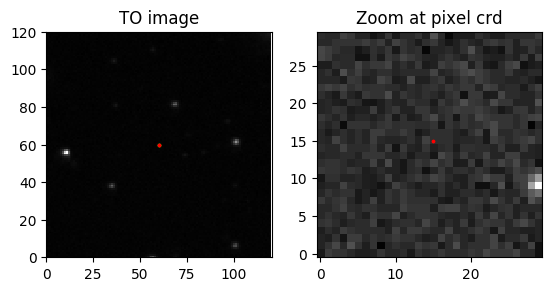

Pixel coordinates: [[ 60.01834016  60.00682923]]
Date of observation: 01_10NOV0


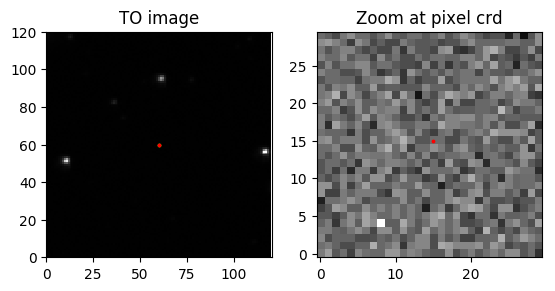

Pixel coordinates: [[ 60.02101587  68.00636354]]
Date of observation: 01_10NOV0


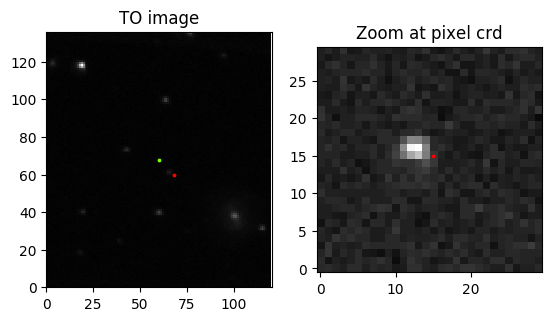

Pixel coordinates: [[ 60.02095237  68.00626575]]
Date of observation: 01_10NOV0


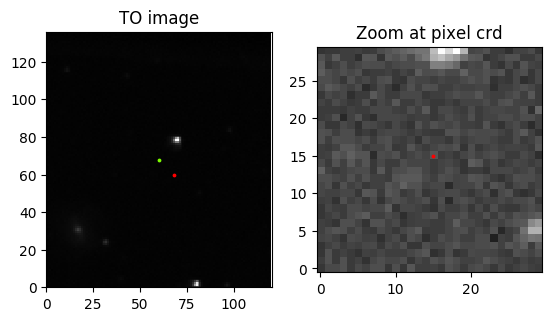

Pixel coordinates: [[ 60.01840578  60.00690327]]
Date of observation: 01_10OCT1


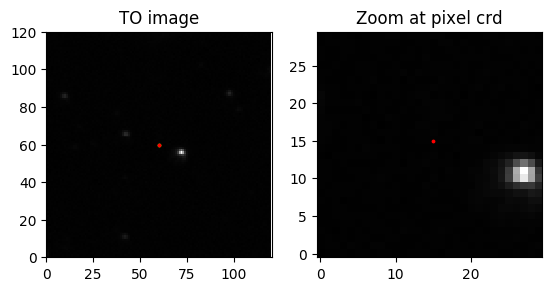

Pixel coordinates: [[ 60.02099989  68.00633318]]
Date of observation: 01_10OCT1


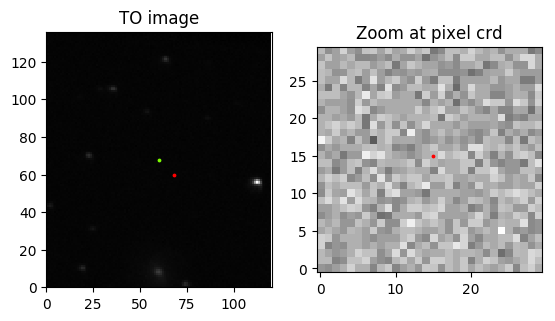

Pixel coordinates: [[ 60.0183866   60.00689687]]
Date of observation: 01_10OCT1


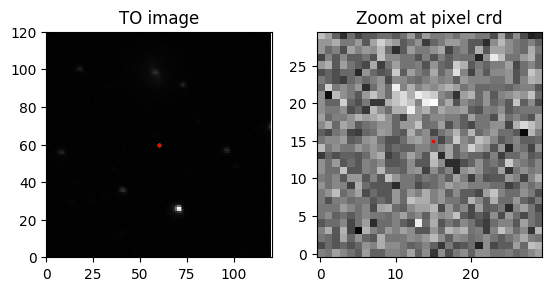

Pixel coordinates: [[ 60.02100299  68.00633916]]
Date of observation: 01_10OCT1


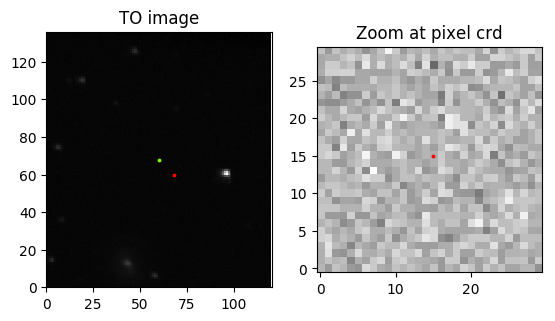

Pixel coordinates: [[ 60.01840215  60.00691035]]
Date of observation: 01_10OCT1


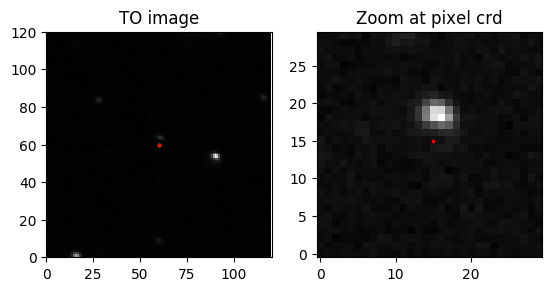

Pixel coordinates: [[ 60.02099624  68.00634126]]
Date of observation: 01_10OCT1


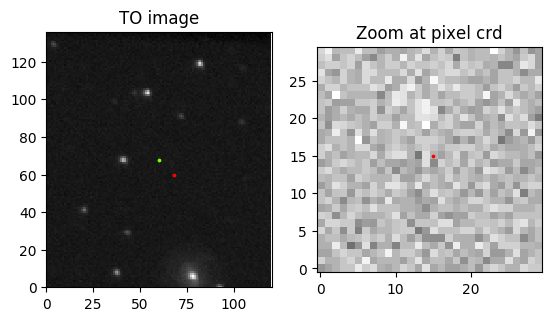

Pixel coordinates: [[ 60.02103529  68.00632616]]
Date of observation: 01_11JUL0


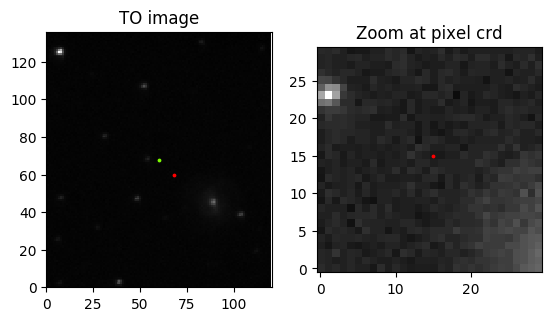

Pixel coordinates: [[ 60.02101193  68.00631849]]
Date of observation: 01_11JUL0


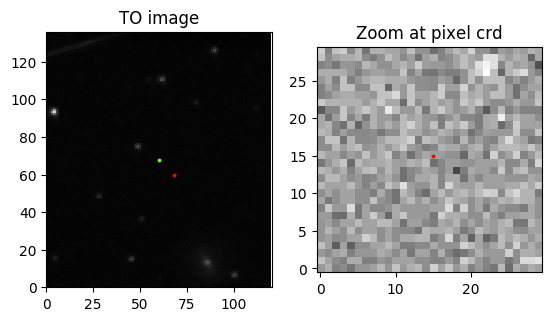

Pixel coordinates: [[ 60.02103517  68.00632946]]
Date of observation: 01_11JUL0


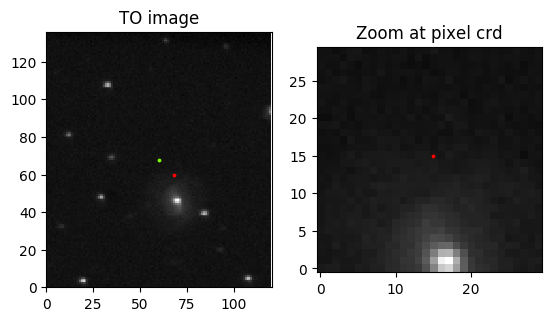

Pixel coordinates: [[ 60.02102721  68.00632942]]
Date of observation: 01_11JUL0


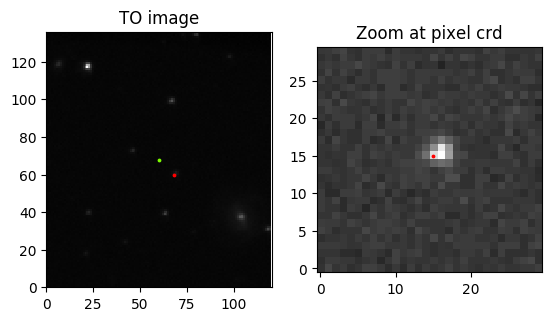

Pixel coordinates: [[ 60.01844572  60.00720998]]
Date of observation: 01_11OCT1


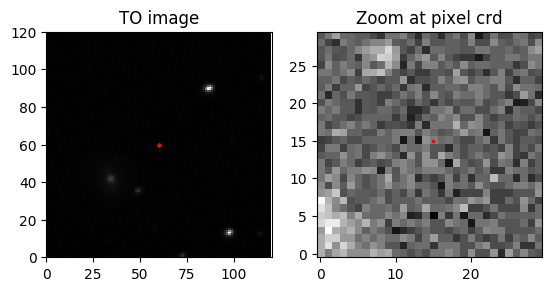

Pixel coordinates: [[ 60.01843306  60.00730452]]
Date of observation: 01_11OCT1


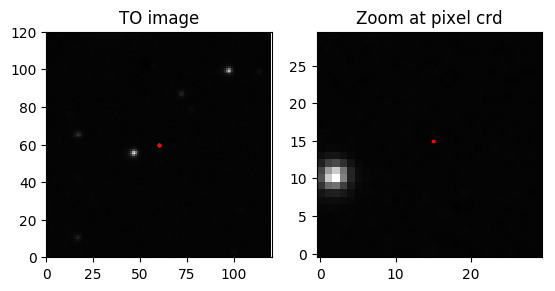

Pixel coordinates: [[ 60.01842121  60.00720446]]
Date of observation: 01_11OCT1


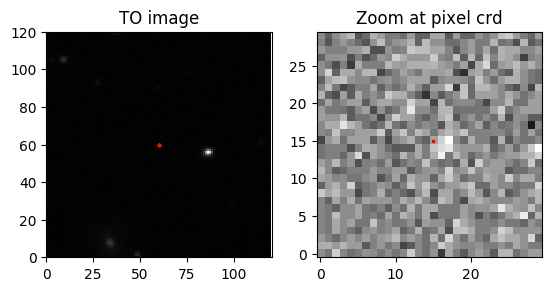

Pixel coordinates: [[ 60.01844152  60.00721764]]
Date of observation: 01_11OCT1


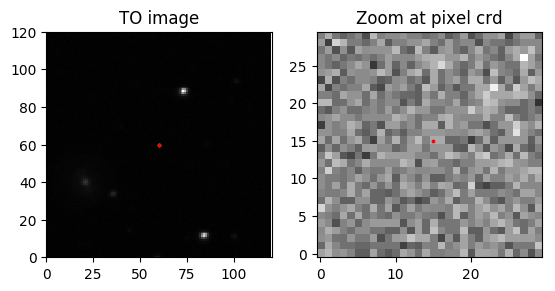

Pixel coordinates: [[ 60.01843544  60.00721919]]
Date of observation: 01_11OCT1


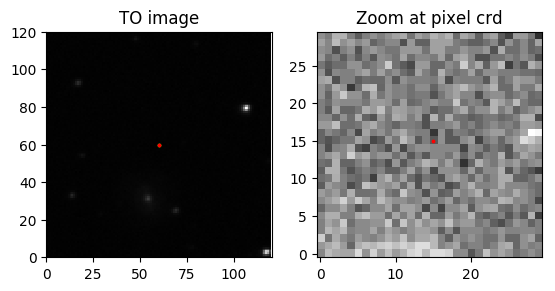

Pixel coordinates: [[ 60.02099603  68.00641339]]
Date of observation: 01_12AUG2


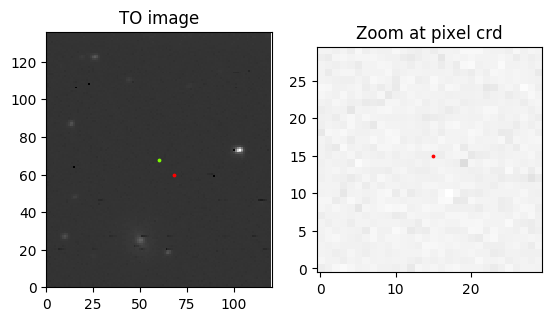

Pixel coordinates: [[ 60.01838914  60.00696795]]
Date of observation: 01_12AUG2


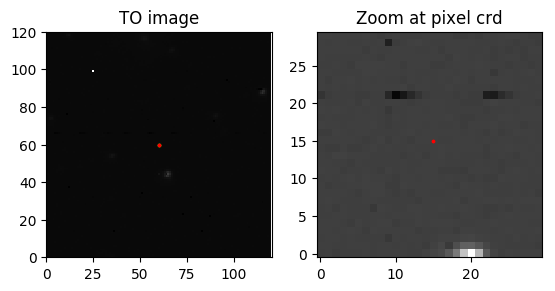

Pixel coordinates: [[ 60.02099791  68.00641962]]
Date of observation: 01_12AUG2


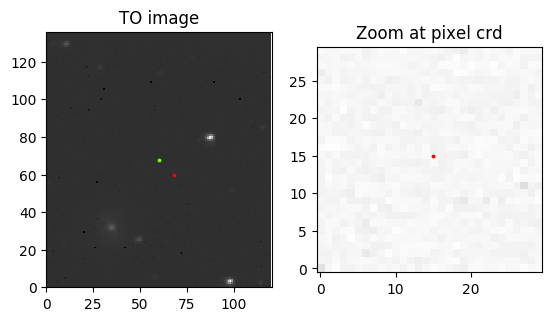

Pixel coordinates: [[ 60.02099461  68.00641943]]
Date of observation: 01_12AUG2


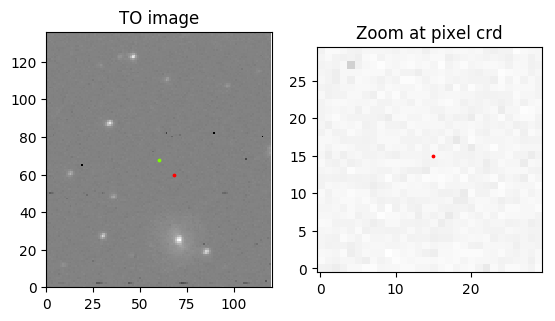

Pixel coordinates: [[ 59.98344323  60.0091178 ]]
Date of observation: 01_12JUN2


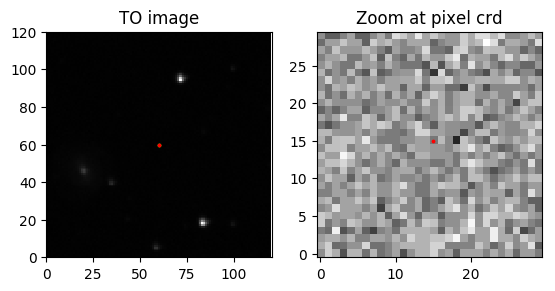

Pixel coordinates: [[ 59.98346022  60.00910904]]
Date of observation: 01_12JUN2


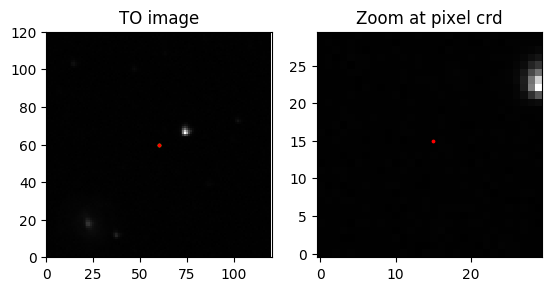

Pixel coordinates: [[ 59.9835007   60.00903378]]
Date of observation: 01_12JUN2


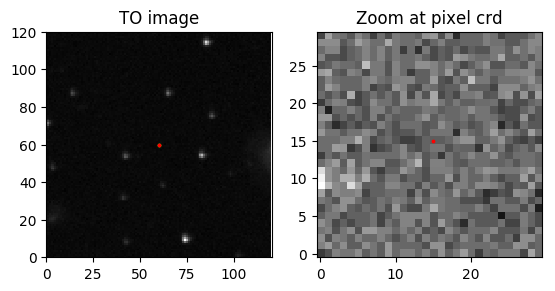

Pixel coordinates: [[ 59.98343767  60.0091185 ]]
Date of observation: 01_12JUN2


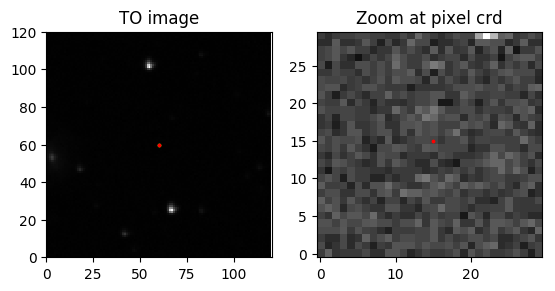

Pixel coordinates: [[ 59.98344086  60.00911626]]
Date of observation: 01_12JUN2


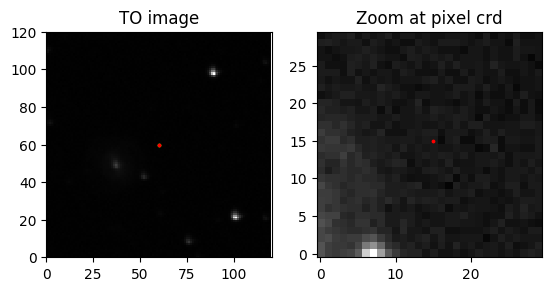

Pixel coordinates: [[ 75.02244252  60.0115496 ]]
Date of observation: 01_12NOV0


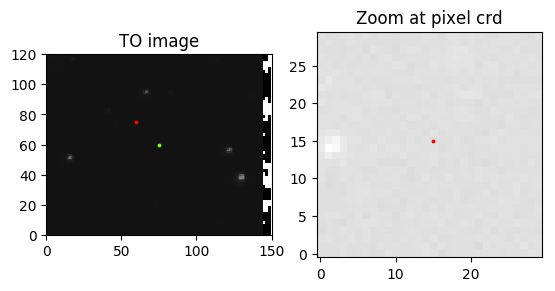

Pixel coordinates: [[ 75.0224228   60.01154241]]
Date of observation: 01_12NOV0


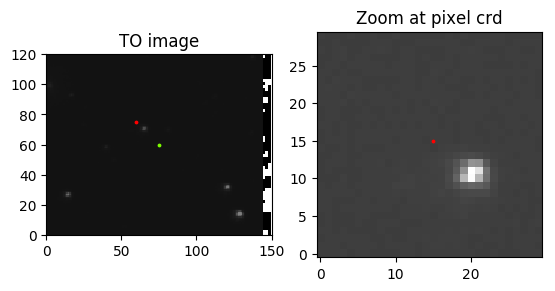

Pixel coordinates: [[ 60.02093706  68.00629907]]
Date of observation: 01_12NOV0


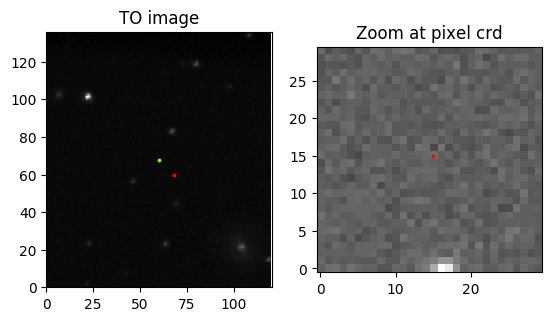

Pixel coordinates: [[ 75.02568804  68.01091507]]
Date of observation: 01_12NOV0


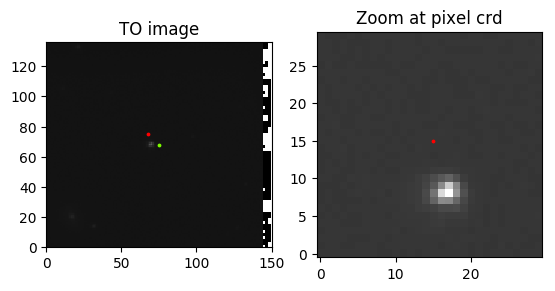

Pixel coordinates: [[ 60.02102192  68.00641405]]
Date of observation: 01_12OCT1


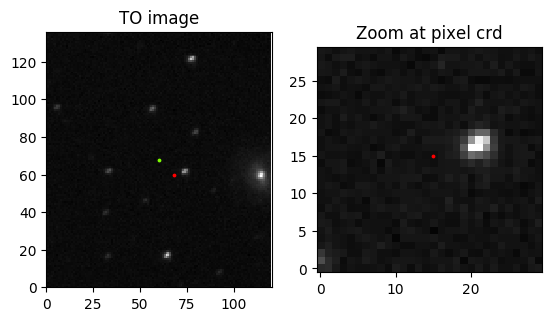

Pixel coordinates: [[ 60.02099816  68.00640578]]
Date of observation: 01_12OCT1


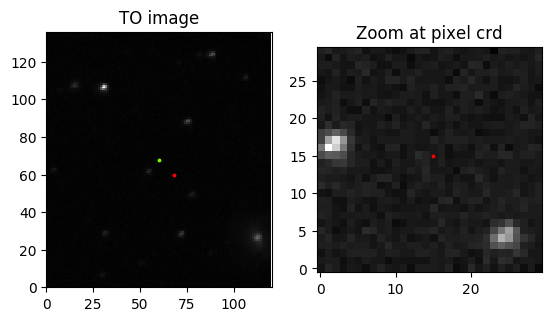

Pixel coordinates: [[ 60.02101899  68.0064172 ]]
Date of observation: 01_12OCT1


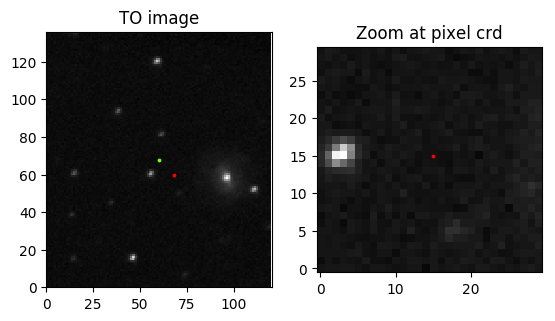

Pixel coordinates: [[ 60.02095527  68.00631701]]
Date of observation: 01_12OCT1


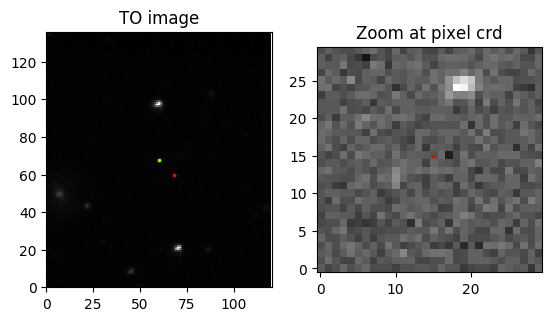

Pixel coordinates: [[ 60.02105544  68.00642911]]
Date of observation: 01_12SEP1


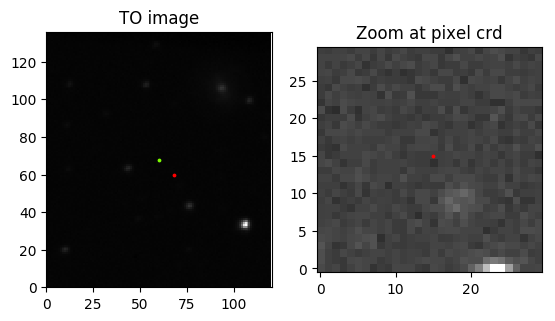

Pixel coordinates: [[ 60.02103018  68.00642236]]
Date of observation: 01_12SEP1


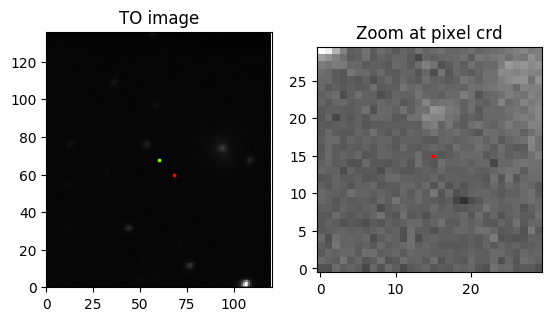

Pixel coordinates: [[ 60.02104966  68.00643212]]
Date of observation: 01_12SEP1


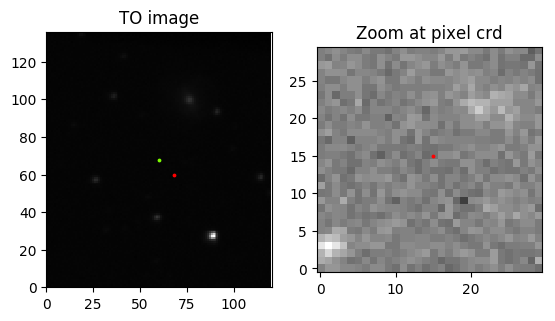

Pixel coordinates: [[ 60.02104061  68.00643302]]
Date of observation: 01_12SEP1


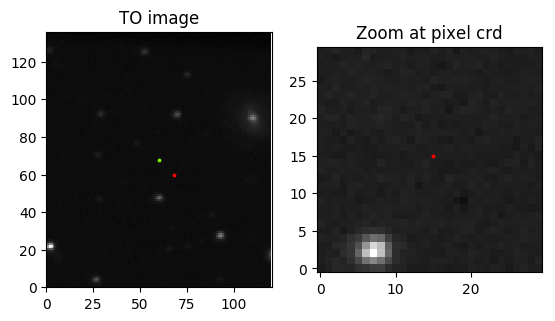

Pixel coordinates: [[ 60.02106906  68.00650809]]
Date of observation: 01_12SEP2


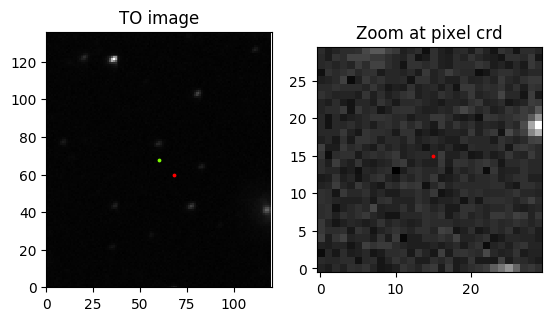

Pixel coordinates: [[ 60.02101147  68.00640792]]
Date of observation: 01_12SEP2


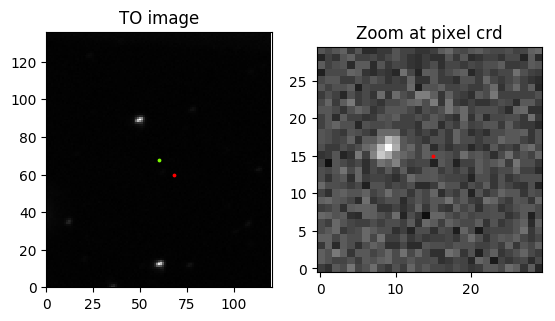

Pixel coordinates: [[ 60.021042    68.00650193]]
Date of observation: 01_12SEP2


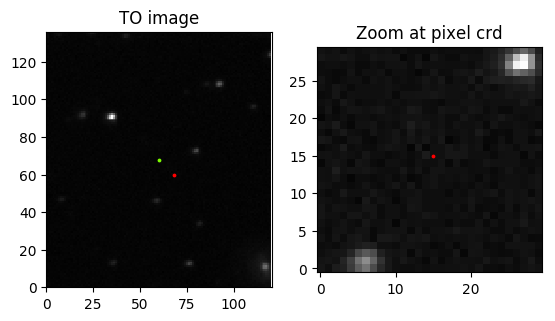

Pixel coordinates: [[ 60.02098495  68.00640191]]
Date of observation: 01_12SEP2


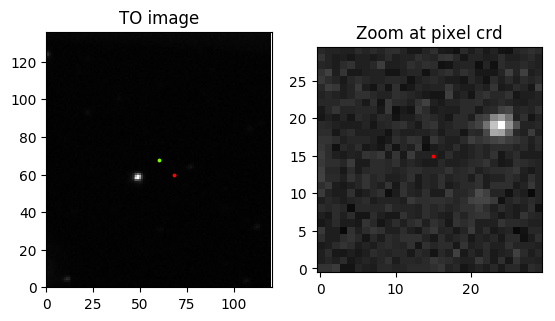

Pixel coordinates: [[ 60.02106976  68.00651273]]
Date of observation: 01_12SEP2


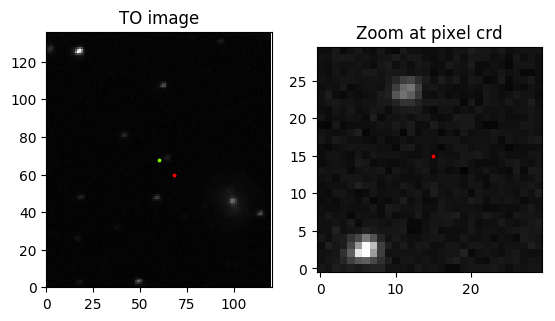

Pixel coordinates: [[ 60.02100651  68.00641294]]
Date of observation: 01_12SEP2


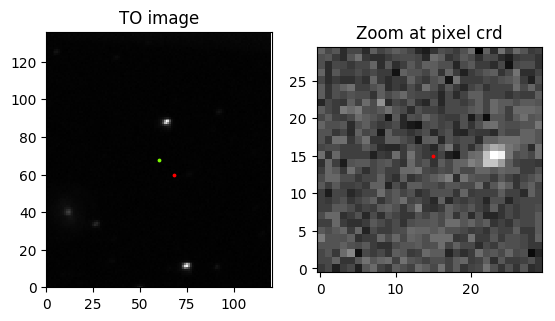

Pixel coordinates: [[ 60.01840446  60.00690568]]
Date of observation: 02_09SEP2


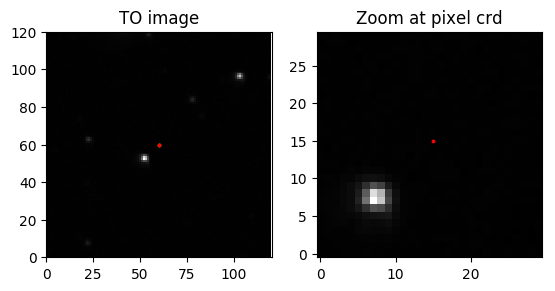

Pixel coordinates: [[ 60.02099787  68.00633603]]
Date of observation: 02_09SEP2


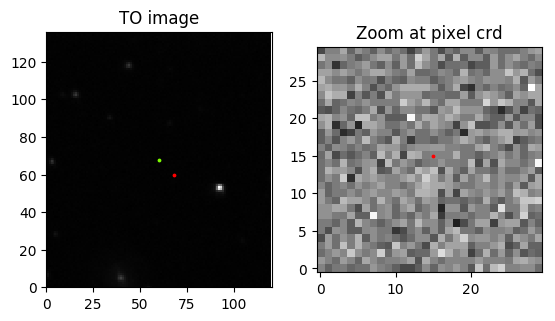

Pixel coordinates: [[ 60.0183901   60.00690133]]
Date of observation: 02_09SEP2


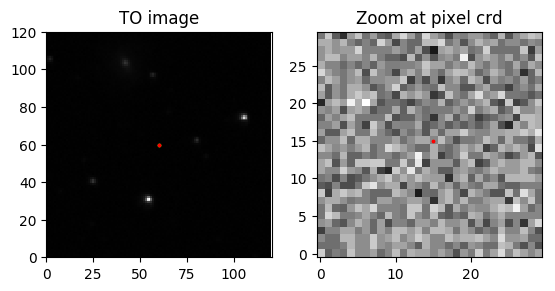

Pixel coordinates: [[ 60.01840274  60.00691018]]
Date of observation: 02_09SEP2


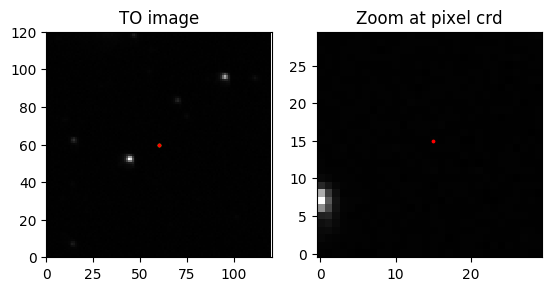

Pixel coordinates: [[ 60.01839919  60.00691096]]
Date of observation: 02_09SEP2


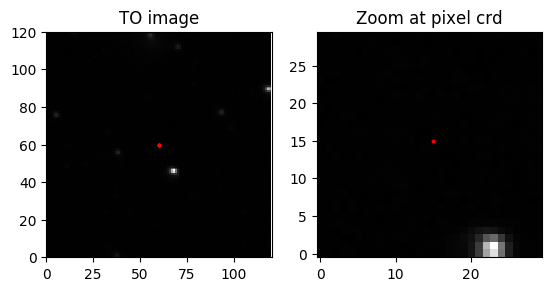

In [82]:
#Extract the name of the .fits file from the DF
#read pkl file if it is already saved
#out_dir = '/home/oem/Documentos/Astronomy/CRTS/Data/'
out_dir = '/Users/j1k1000o/Documents/Cata/Data/'
object_class = 'SN'
file_name = 'first_object.zip'
complete_path = out_dir + object_class + '/'
path_to_file = complete_path + file_name[0:-4] + '/'
df_per_object = pd.read_pickle(path_to_file + 'first_object.pkl')
df_per_object = df_per_object.sort_values('FILENAME')
fig = plt.figure()
for index, row in df_per_object.iterrows():
    file_name_from_df = row['FILENAME']
    ra_crd_from_df = float(row['CENTER_RA'])
    dec_crd_from_df = float(row['CENTER_DEC'])
    hdu_list = fits.open(path_to_file + file_name_from_df)
    image_data = hdu_list[0].data
    image_data = image_data.astype(np.float32)
    image_data = image_data - np.min(image_data)
    scaled_image_data = image_data *(255/np.max(image_data))
    scaled_image_data = scaled_image_data.astype(int)
    #world2pix
    w = wcs.WCS(hdu_list[0].header)
    ra_dec_crd = w.wcs.crval
    #worldcrd = np.array([[ra_dec_crd[0], ra_dec_crd[1]]]) #crds from metadata
    worldcrd = np.array([[ra_crd_from_df, dec_crd_from_df]]) 
    pixcrd = w.wcs_world2pix(worldcrd, 1)
    rows = pixcrd[0,0] #y
    cols = pixcrd[0,1] #x
    print('Pixel coordinates:',pixcrd)
    print('Date of observation:', file_name_from_df[0:9])
    #plot the image and ra/dec crds
    f, (ax1, ax2) = plt.subplots(1, 2,)#,  gridspec_kw = {'width_ratios':[3, 1]})
    ax1.imshow(scaled_image_data, cmap='gray',origin='lower', vmin=0, vmax=255)
    ax1.scatter(rows, cols, color='lawngreen',s=3)
    ax1.scatter(cols, rows, color='r',s=3)
    ymin =0
    xmin = 0
    ymax_o, xmax_o = np.shape(image_data)
    ax1.set_ylim([ymin,ymax_o])
    ax1.set_xlim([xmin,xmax_o])
    ax1.set_title('TO image')
    #extract a vicinity around the pixelcrd
    ww = 15
    image_sub_sampled = image_data[int(rows)-ww:int(rows)+ww, int(cols)-ww:int(cols)+ww]
    ax2.imshow(image_sub_sampled, cmap='gray',origin='lower', vmin=0, vmax=np.max(image_sub_sampled))
    ymin =0
    xmin = 0
    ymax, xmax = np.shape(image_sub_sampled)
    ax2.scatter(int(ymax/2), int(xmax/2) ,color='r',s=3)
  
    #ax2.set_ylim([ymin,ymax])
    #ax2.set_xlim([xmin,xmax])
    ax2.set_title('Zoom at pixel crd')
    plt.show()
    #print(file_name_from_df)

In [83]:
for index, row in df_per_object.iterrows():
    file_name_from_df = row['FILENAME']
    #print(file_name_from_df)
    
df_per_object.head(20)

CENTER_DEC      CENTER_RA                                 FILENAME  \
54  -22.6571085044  332.667502722  01_03NOV21_S21112_0004_cutout_0407.fits   
91  -22.6183459468  332.657924237  01_03NOV22_S23110_0001_cutout_3233.fits   
93  -22.6177019891  332.670656085  01_03NOV22_S23110_0002_cutout_3233.fits   
90  -22.6167236628  332.655498379  01_03NOV22_S23110_0003_cutout_3233.fits   
70  -22.7057141619  332.665858778  01_03NOV22_S23110_0004_cutout_3232.fits   
95  -22.6152296653  332.666220396  01_03NOV22_S23110_0004_cutout_3233.fits   
63  -22.6888653653   332.64374002  01_05NOV13_S23110_0001_cutout_3232.fits   
13  -22.6350490277  332.611082542  01_05OCT10_S23110_0001_cutout_3233.fits   
88   -22.621573152  332.612713104  01_05OCT10_S23110_0002_cutout_3233.fits   
21  -22.6383385109  332.622078449  01_05OCT10_S23110_0003_cutout_3233.fits   
14   -22.636003043  332.606782998  01_05OCT10_S23110_0004_cutout_3233.fits   
92  -22.6187670638  332.650798213  01_05SEP26_S23109_0001_cutout_0333.fits   
2   -22.6957996987  332.605028823  01_05SEP26_S23109_0002_cutout_0432.fits   
29  -22.6240399751  332.661780159  01_05SEP26_S23109_0003_cutout_0433.fits   
87  -22.6228428658  332.611684977  01_05SEP26_S23109_0004_cutout_0533.fits   
51  -22.6678175181   332.63450311  01_06NOV17_S23110_0002_cutout_3232.fits   
4   -22.6849051517  332.625899821  01_06NOV17_S23110_0003_cutout_3232.fits   
69  -22.6829951824  332.644464896  01_06NOV17_S23110_0004_cutout_3232.fits   
53  -22.6632679065  332.672345698  01_07OCT10_S23110_0001_cutout_3133.fits   
32  -22.6513448822  332.671785248  01_07OCT10_S23110_0002_cutout_3133.fits   

      OBS-DATE  
54  2003-11-21  
91  2003-11-22  
93  2003-11-22  
90  2003-11-22  
70  2003-11-22  
95  2003-11-22  
63  2005-11-13  
13  2005-10-10  
88  2005-10-10  
21  2005-10-10  
14  2005-10-10  
92  2005-09-26  
2   2005-09-26  
29  2005-09-26  
87  2005-09-26  
51  2006-11-17  
4   2006-11-17  
69  2006-11-17  
53  2007-10-10  
32  2007-10-10

min and max: 0 255
Pixel coordinates: [[ 59.98307669  60.00845027]]


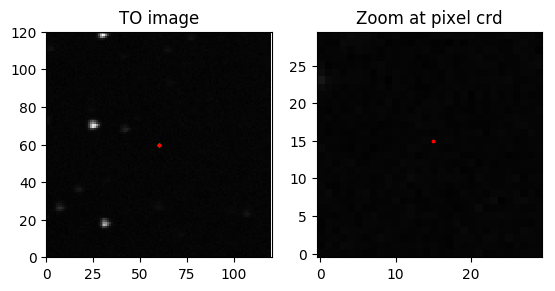

In [74]:
nombre = '01_03NOV21_S21112_0004_cutout_0407.fits'
ra_crd_from_df = 332.667502722
dec_crd_from_df = -22.6571085044
hdu_list = fits.open(path_to_file + nombre)
image_data = hdu_list[0].data
image_data = image_data.astype(np.float32)
image_data = image_data - np.min(image_data)
scaled_image_data = image_data *(255/np.max(image_data))
scaled_image_data = scaled_image_data.astype(int)
print('min and max:', np.min(scaled_image_data), np.max(scaled_image_data))
w = wcs.WCS(hdu_list[0].header)
ra_dec_crd = w.wcs.crval
#worldcrd = np.array([[ra_dec_crd[0], ra_dec_crd[1]]]) #crds from metadata
worldcrd = np.array([[ra_crd_from_df, dec_crd_from_df]]) 
pixcrd = w.wcs_world2pix(worldcrd, 1)
print('Pixel coordinates:',pixcrd)
#plot the image and ra/dec crds
f, (ax1, ax2) = plt.subplots(1, 2,)#,  gridspec_kw = {'width_ratios':[3, 1]})
ax1.imshow(scaled_image_data, cmap='gray',origin='lower', vmin=0, vmax=255)
ax1.scatter(pixcrd[0,0], pixcrd[0,1],color='lawngreen',s=3)
ax1.scatter((pixcrd[0,1]), (pixcrd[0,0]),color='r',s=3)
ymin =0
xmin = 0
ymax_o, xmax_o = np.shape(image_data)
ax1.set_ylim([ymin,ymax_o])
ax1.set_xlim([xmin,xmax_o])
ax1.set_title('TO image')
#extract a vicinity around the pixelcrd
ww = 15
image_sub_sampled = scaled_image_data[int(pixcrd[0,1])-ww:int(pixcrd[0,1])+ww, int(pixcrd[0,0])-ww:int(pixcrd[0,0])+ww]
max_subsampled = np.max(image_sub_sampled)
ax2.imshow(image_sub_sampled, cmap='gray',origin='lower', vmin=0, vmax=255)
ymin =4
xmin = 0
ymax, xmax = np.shape(image_sub_sampled)
ax2.scatter(int(ymax/2), int(xmax/2) ,color='r',s=3)

#ax2.set_ylim([ymin,ymax])
#ax2.set_xlim([xmin,xmax])
ax2.set_title('Zoom at pixel crd')
plt.show()
#print(file_name_from_df)

In [73]:
max_subsampled

23